# Imports

In [46]:
import shutil
import numpy
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models, datasets
import torch.nn.functional as F
import os
from torchvision.utils import make_grid
from PIL import Image
import random
import shutil
import statistics as st
import pickle
import cv2
# from skimage.util import view_as_blocks
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import confusion_matrix, classification_report
import os


In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Args

In [48]:
class Args():
    def __init__(self):
        self.num_class = 12
        self.batchsize = 16
        self.lr = 0.0001
        self.epoch = 50
        self.crop_size = 299
        self.train_ratio = 0.6
        self.valid_ratio = 0.2
        self.test_ratio = 0.2
        self.num_workers = 8

args = Args()
input_dir = 'C:/Users/LENOVO/Desktop/Datasets/Rice Pest Detection/All images'
output_dir = 'C:/Users/LENOVO/Desktop/Datasets/Rice Pest Detection'


# Dataset

In [12]:
# from google.colab import drive
# drive.mount('/content/drive')

In [49]:

for split in ['Train', 'Valid', 'Test']:
    split_path = os.path.join(output_dir, split)
    os.makedirs(split_path, exist_ok=True)

In [50]:
for class_name in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    total = len(images)
    train_count = int(total * args.train_ratio)
    valid_count = int(total * args.valid_ratio)
    test_count = total - train_count - valid_count

    train_images = images[:train_count]
    valid_images = images[train_count:train_count + valid_count]
    test_images = images[train_count + valid_count:]

    for split, split_images in zip(['Train', 'Valid', 'Test'],
                                   [train_images, valid_images, test_images]):
        split_class_dir = os.path.join(output_dir, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)
        for img_name in split_images:
            src = os.path.join(class_path, img_name)
            dst = os.path.join(split_class_dir, img_name)
            shutil.copy2(src, dst)



In [51]:
train_transform = transforms.Compose([
    transforms.ColorJitter(brightness=random.uniform(0.0,0.5), contrast=random.uniform(0.0,0.5), saturation=random.uniform(0.0,0.5)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor()
])

test_valid_transform = transforms.Compose([
    transforms.ToTensor()
    ])

train_dataset = datasets.ImageFolder(root=os.path.join(output_dir, 'Train'), transform=train_transform) \
#  + datasets.ImageFolder(root=os.path.join(output_dir, 'Train'), transform=test_valid_transform) #Augmented Dataset
test_dataset = datasets.ImageFolder(root=os.path.join(output_dir, 'Test'), transform=test_valid_transform)
valid_dataset = datasets.ImageFolder(root=os.path.join(output_dir, 'Valid'), transform=test_valid_transform)

# Data Loaders

In [77]:
train_loader = DataLoader(train_dataset, batch_size=args.batchsize, shuffle=True, num_workers=args.num_workers)
test_loader = DataLoader(test_dataset, batch_size=args.batchsize, shuffle=True, num_workers=args.num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=args.batchsize, shuffle=False, num_workers=args.num_workers)

# Model

In [53]:
def set_parameter_requires_grad(model, feature_extracting):
    for param in model.parameters():
      param.requires_grad = not feature_extracting


def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224


    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained = use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained = use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft



# Train

In [54]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()


    loss_dict = {'train':[],'val':[]}
    acc_dict = {'train':[],'val':[]}

    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 +  0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)


            loss_dict[phase].append(epoch_loss)
            acc_dict[phase].append(epoch_acc)


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                PATH = "best.pt"
                torch.save(model.state_dict(), PATH)


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))


    return model, loss_dict,  acc_dict



# Training

In [55]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

criterion = nn.CrossEntropyLoss()

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

# Initialize the model for this run
model = initialize_model(model_name, args.num_class, feature_extract, use_pretrained=True)

# Send the model to GPU
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=args.lr)

d:\Anaconda\envs\torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\envs\torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [56]:
dataloaders_dict = {'train': train_loader, 'val': valid_loader}
model, loss_dict, acc_dict = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs = args.epoch , is_inception = False)

Epoch 0/49
----------
train Loss: 0.8683 Acc: 0.7541
val Loss: 0.3591 Acc: 0.8972

Epoch 1/49
----------
train Loss: 0.2636 Acc: 0.9313
val Loss: 0.2213 Acc: 0.9508

Epoch 2/49
----------
train Loss: 0.1706 Acc: 0.9545
val Loss: 0.1869 Acc: 0.9586

Epoch 3/49
----------
train Loss: 0.1321 Acc: 0.9655
val Loss: 0.1390 Acc: 0.9683

Epoch 4/49
----------
train Loss: 0.0890 Acc: 0.9776
val Loss: 0.1100 Acc: 0.9754

Epoch 5/49
----------


KeyboardInterrupt: 

# Test

In [57]:
import numpy as np

def test(model , test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    All_preds = []
    All_labels = []
    k = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels =  labels.to(device)
            preds = model(images)
            loss = criterion(preds , labels)
            test_loss += loss * images.shape[0]
            preds = torch.argmax(preds , dim = 1)
            All_preds.append(preds.cpu().numpy())
            All_labels.append(labels.cpu().numpy())
            k += images.shape[0]

            correct += (preds == labels).float().sum()
        print(labels)
        print(preds)
        accuracy = correct / k
        epoch_loss = test_loss / k
        print("   loss:%.2f" %epoch_loss.item() , "  Acc:%.2f" %accuracy.item())
        All_labels = np.concatenate( All_labels, axis=0 )
        All_preds = np.concatenate( All_preds, axis=0 )
    return All_labels ,All_preds

In [59]:
All_labels ,All_preds = test(model, train_loader, criterion)
print(confusion_matrix(All_labels ,All_preds))
print(classification_report(All_labels ,All_preds))

tensor([11,  2,  4,  7,  4, 11,  5,  0,  9,  6,  8,  7,  3,  3, 10,  8],
       device='cuda:0')
tensor([11,  2,  4,  7,  4, 11,  5,  0,  9,  6,  8,  7,  3,  3, 10,  8],
       device='cuda:0')
   loss:0.05   Acc:0.99
[[442   0   0   0   0   0   3   0   0   0   0   2]
 [  0 171   3   0   0   0   0   0   0   0   0   0]
 [  0   1 194   0   0   0   0   0   0   0   0   0]
 [  0   0   0 474   0   0   0   0   0   0   0   0]
 [  0   0   0   0 285   0   0   0   0   0   0   0]
 [  0   0   0   0   0 410   0   0   1   0   0   0]
 [  0   0   0   0   0   0 363   0   0   0   0   0]
 [  0   0   0   0   0   0   1 287   0   0   0   0]
 [  0   0   0   0   0   3   0   0 663   0   0   0]
 [  0   5   0   0   0   1   0   4   2 704   0   0]
 [  0   0   0   0   0   0   0   0   0   0 348   0]
 [ 24   0   0   0   0   5   0   0   0   0   0 244]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       447
           1       0.97      0.98      0.97       174
      

In [43]:
import torchvision.models as models
import torch.nn as nn

# Recreate your model structure
model = models.resnet18(pretrained=False)
num_classes = 12
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load('best.pt'))

d:\Anaconda\envs\torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

# Grad CAM

In [72]:
def getCAM(feature_conv, weight_fc, class_idx, image_idx):
    """
    Generate Grad-CAM for a specific image in the batch.
    
    Arguments:
    - feature_conv: The activations from the last convolutional layer (layer4 in ResNet-18).
    - weight_fc: The weights from the fully connected layer.
    - class_idx: The index of the class for which Grad-CAM is computed.
    - image_idx: The index of the image in the batch.
    
    Returns:
    - cam_img: The Grad-CAM heatmap for the specified image.
    """
    _, nc, h, w = feature_conv.shape
    # Select the activations for the specific image in the batch
    feature_map = feature_conv[image_idx, :, :, :]  # (nc, h, w)
    
    # Compute the Class Activation Map (CAM) by multiplying class weights with the feature map
    cam = weight_fc[class_idx].dot(feature_map.reshape((nc, h * w)))
    cam = cam.reshape(h, w)
    
    # Normalize the CAM to have values between 0 and 1
    cam = cam - np.min(cam)  # Ensure non-negative values
    cam_img = cam / np.max(cam)  # Normalize to [0, 1]
    
    return cam_img


In [73]:
# Extract  pretrained activations
class SaveFeatures():
    """ Extract pretrained activations"""
    features=None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self):
        self.hook.remove()

In [74]:
def My_GradCAM(model, test_loader):
    model.eval()
    model.load_state_dict(torch.load('best.pt'))
    
    # Grab one batch of images
    image = next(iter(test_loader))[0].to(device)
    
    # Extract pretrained activations from ResNet-18 'layer4' (last conv block)
    final_layer = model._modules.get('fc')  # Final fully connected layer
    activated_features = SaveFeatures(model.layer4)  # Get activations from 'layer4'
    
    # Probabilities & labels for each image
    output = model(image)  # Forward pass
    probabilities = F.softmax(output, dim=1).data.squeeze()  # Softmax probabilities
    pred_idx = np.argmax(probabilities.cpu().detach().numpy(), axis=1)
    labels = pred_idx
    activated_features.remove()  # Remove hooks after capturing activations
    
    # Get weight parameters for softmax (fully connected layer)
    weight_softmax_params = list(model._modules.get('fc').parameters())
    weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())
    
    # Prepare current images and heatmaps
    cur_images = image.cpu().numpy().transpose((0, 2, 3, 1))
    heatmaps = []
    
    for i in range(len(pred_idx)):  # Iterate over each image in the batch
        img = getCAM(activated_features.features, weight_softmax, pred_idx[i], i)
        heatmaps.append(img)
    
    # Calculate probability for each image
    proba = []
    for i in probabilities.cpu().detach().numpy():
        idx = np.argmax(i)
        proba.append((str(np.round(i[idx] * 100, 2))) + '%')
    
    # Plot the images and their corresponding heatmaps
    fig = plt.figure(figsize=(20, 15))
    for i in range(0, len(cur_images[:8])):  # Displaying the first 8 images
        img = cur_images[i]
        mask = heatmaps[i]
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        plt.imshow(img)
        plt.imshow(cv2.resize(mask, (512, 512), interpolation=cv2.INTER_LINEAR), alpha=0.5, cmap='jet')
        ax.set_title(f'Label {labels[i]} with {proba[i]} probability', fontsize=14)

    # Add colorbar for Grad-CAM heatmap
    cax = fig.add_axes([0.32, 0.42, 0.4, 0.03])  # place where the map will be
    clb = plt.colorbar(cax=cax, orientation='horizontal', ticks=[0, 0.5, 1])
    clb.ax.set_title('Level of "attention" NN in making prediction', fontsize=20)
    clb.ax.set_xticklabels(['low', 'medium', 'high'], fontsize=18)

    plt.show()


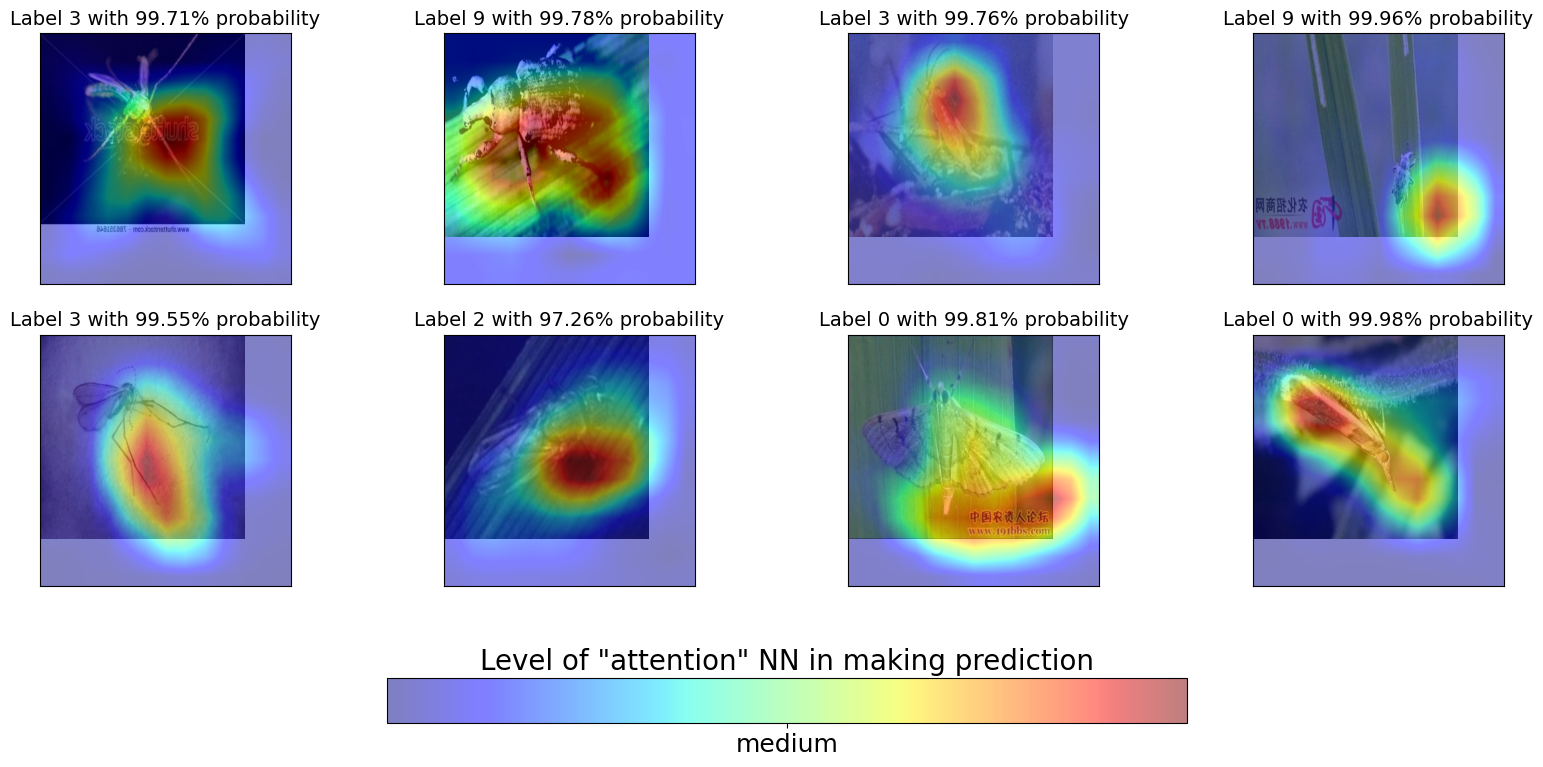

In [78]:
My_GradCAM(model , test_loader)